In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

class ResUNet(nn.Module):
    def __init__(self, in_channels=3):
        super(ResUNet, self).__init__()

        # Define a convolutional block: consists of two Conv2d layers with ReLU activation
        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),  # Convolutional layer
                nn.ReLU(inplace=True),  # Activation function
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),  # Convolutional layer
                nn.ReLU(inplace=True)  # Activation function
            )

        # Define a residual block: consists of two Conv2d layers with BatchNorm and ReLU activation
        def residual_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),  # Convolutional layer
                nn.BatchNorm2d(out_channels),  # Batch normalization
                nn.ReLU(inplace=True),  # Activation function
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),  # Convolutional layer
                nn.BatchNorm2d(out_channels)  # Batch normalization
            )

        # Encoder stages
        self.encoder1 = conv_block(in_channels, 64)  # First encoder block
        self.encoder2 = conv_block(64, 128)  # Second encoder block
        self.encoder3 = conv_block(128, 256)  # Third encoder block

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling layer for downsampling

        # Middle stage using a residual block
        self.middle = residual_block(256, 512)  # Bottleneck block

        # Decoder stages
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)  # Upsampling layer
        self.decoder3 = conv_block(512, 256)  # Decoder block 3

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)  # Upsampling layer
        self.decoder2 = conv_block(256, 128)  # Decoder block 2

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)  # Upsampling layer
        self.decoder1 = conv_block(128, 64)  # Decoder block 1

        # Final output layer: outputting the number of channels specified by in_channels
        self.output_conv = nn.Conv2d(64, in_channels, kernel_size=1)

    def forward(self, x):
        # Forward pass through the encoder
        enc1 = self.encoder1(x)  # First encoder
        enc2 = self.encoder2(self.pool(enc1))  # Second encoder
        enc3 = self.encoder3(self.pool(enc2))  # Third encoder

        # Forward pass through the middle stage
        middle = self.middle(self.pool(enc3))  # Bottleneck block

        # Forward pass through the decoder
        dec3 = self.upconv3(middle)  # Upsampling
        dec3 = self.center_crop(dec3, enc3.size()[2:])  # Crop to match size
        dec3 = torch.cat((dec3, enc3), dim=1)  # Concatenate with encoder feature
        dec3 = self.decoder3(dec3)  # Decoder block 3

        dec2 = self.upconv2(dec3)  # Upsampling
        dec2 = self.center_crop(dec2, enc2.size()[2:])  # Crop to match size
        dec2 = torch.cat((dec2, enc2), dim=1)  # Concatenate with encoder feature
        dec2 = self.decoder2(dec2)  # Decoder block 2

        dec1 = self.upconv1(dec2)  # Upsampling
        dec1 = self.center_crop(dec1, enc1.size()[2:])  # Crop to match size
        dec1 = torch.cat((dec1, enc1), dim=1)  # Concatenate with encoder feature
        dec1 = self.decoder1(dec1)  # Decoder block 1

        output = self.output_conv(dec1)  # Final output
        return output

    def center_crop(self, layer, target_size):
        # Function to center crop the layer to a specific target size
        _, _, layer_height, layer_width = layer.size()  # Get the dimensions of the layer
        diff_y = (layer_height - target_size[0]) // 2  # Calculate vertical difference
        diff_x = (layer_width - target_size[1]) // 2  # Calculate horizontal difference
        return layer[:, :, diff_y:diff_y + target_size[0], diff_x:diff_x + target_size[1]]  # Return cropped layer


In [2]:
device = "cpu"
model = ResUNet().to(device)
state_dict = torch.load("./model_weights.pth", map_location=torch.device('cpu'))
model.load_state_dict(state_dict)

C:\Users\haesol\AppData\Local\Temp\ipykernel_9572\3861608842.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("./model_weights.pth", map_location=

<All keys matched successfully>

In [3]:
def denorm(img_tensors):
    return img_tensors * 0.5 + 0.5

def create_masked_images(images):
    masked_images = images.clone()
    masked_images[:, :, 14:40, 14:40] = 0  # masking
    return masked_images

In [4]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize images to 64x64 pixels
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the images
])

# Create a dataset for validation images with the specified transformations
dataset = datasets.ImageFolder(root=r"./dataset", transform=transform)  # Set your own validation path here

# Check the class names in the dataset
class_names = dataset.classes
print("클래스 이름:", class_names)

# Specify the desired class names for testing
target_classes = ['test']  # Select the 'test' class

# Get the indices of the selected classes
target_indices = [class_names.index(cls) for cls in target_classes]

# Filter the dataset to include only the selected classes
selected_indices = [i for i, (_, label) in enumerate(dataset) if label in target_indices]

# Create a subset of the dataset with the selected indices
test_data = Subset(dataset, selected_indices)

# Create a DataLoader for the test data
test_Loader = DataLoader(test_data, batch_size=256, shuffle=True)  # Corrected to use 'test_data' instead of 'valid_data'


클래스 이름: ['test']


In [5]:
# 예시 이미지 시각화
images, _ = next(iter(test_Loader))
masked_images = create_masked_images(images)
outputs = model(masked_images.to(device)).cpu().detach()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.3791421..1.5759914].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.3791421..1.5759914].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.43811417..1.5767998].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.55038965..1.6530111].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.55038965..1.6530111].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.62409055..1.7111813].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.43

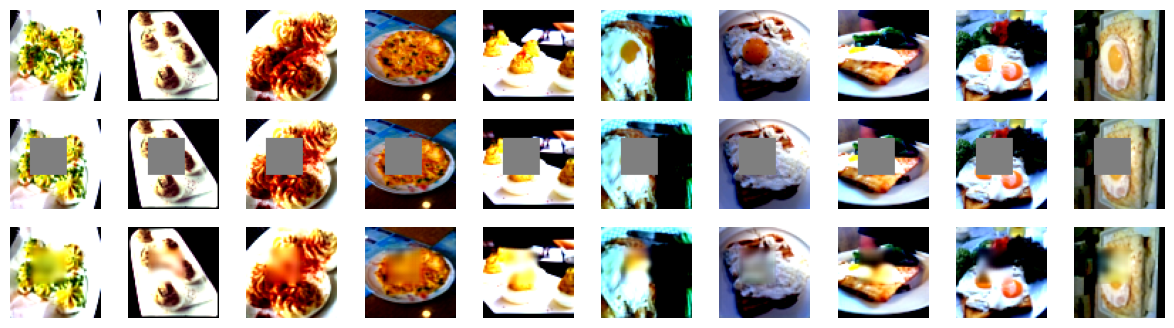

In [6]:
fig, axs = plt.subplots(3, 10, figsize=(15, 4))
for i in range(10):
    axs[0, i].imshow(denorm(images[i]).permute(1, 2, 0))
    axs[1, i].imshow(denorm(masked_images[i].permute(1, 2, 0)))
    axs[2, i].imshow(denorm(outputs[i].permute(1, 2, 0)))  
    axs[0, i].axis('off')
    axs[1, i].axis('off')
    axs[2, i].axis('off')
plt.show()